In [2]:
import pandas as pd
from uncertainties import ufloat
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy import stats

In [3]:
#Función que se encarga de convertir datos numéricos a datos con incertidumbre
def aplicar_incertidumbre(lista_mediciones,sis_error):
    avg=np.mean(lista_mediciones)
    if len(lista_mediciones)>1:
        desv_est=np.std(lista_mediciones, ddof=1)
        #==================Valor de t-student=================
        IC = 0.95     # PASO 1. Intervalo de confianza
        alpha = 1 - IC      # PASO 2. Valor de alpha
        alpha_medios = alpha/2     # PASO 3. Valor de alpha/2
        n = len(lista_mediciones)     # PASO 4. Número de datos 
        v = n - 1     # PASO 5. Grados de libertad (DOF)
        valor = IC + alpha_medios     # PASO 6. Distr. t-Student (t)
        t = stats.t.ppf(valor, v)
        #======================================================
        rand_error=t*desv_est/sp.sqrt(n)
    else:
        rand_error=0
    total_error=sp.sqrt(rand_error**2+sis_error**2)
    return ufloat(avg, total_error)

def interpolar(serie1,serie2,grado,colore="firebrick"):
    values1 = [valor.nominal_value for valor in serie1]
    values2 = [valor.nominal_value for valor in serie2]
    coef = np.polyfit(values1,values2,grado)
    poly1d_fn = np.poly1d(coef)
    x_fit = np.linspace(min(values1), max(values1), 100)
    if grado==2:
        plt.plot(x_fit, poly1d_fn(x_fit),'--', color=colore, linewidth=1, zorder=10)
    else:
        plt.plot(x_fit, poly1d_fn(x_fit),'--', color=colore, linewidth=1, zorder=10,label="Datos interpolados")
    return poly1d_fn
    
#Función para graficar dos arreglos con datos ufloat de uncertainities
def plot_ufloats(serie1,serie2,colore="firebrick"):
    # Extraer valores medidos y incertidumbres
    values1 = [valor.nominal_value for valor in serie1]
    unc1 = [valor.std_dev for valor in serie1]

    values2 = [valor.nominal_value for valor in serie2]
    unc2 = [valor.std_dev for valor in serie2]

    plt.errorbar(values1,values2, xerr=unc1, yerr=unc2, color=colore,ecolor="#191717",elinewidth=0.75,capsize=1, capthick=0.75,linestyle='-',label="Datos experimentales")

fontdictval={'fontsize': 15,'fontname': 'Times New Roman',"color":"firebrick"}

#Función para dar formato a la gráfica
def grafica(titulo,ejex,ejey):
    #=======================Elaboracion ejes==================
    plt.title(titulo, fontdict=fontdictval)
    plt.ylabel(ejey, fontdict=fontdictval)
    plt.xlabel(ejex, fontdict=fontdictval)
    plt.ylim([0,None])
    #==========================Enmallado=================================
    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.minorticks_on()
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', alpha=0.5)
    #=====================================================================
    plt.legend(loc='best', fontsize=11) #Elaboracion del legend
    plt.show()

def aplicar_incertidumbre2(x):
    return aplicar_incertidumbre(x,0.1)



In [4]:
df=pd.DataFrame()
for i in range(1,6):
    dftemp=pd.read_excel("./data/data"+str(i)+".xlsx")
    df = pd.concat([df, dftemp])
df_grouped = df.groupby('RPM (RPM)').agg({
    'Torque (ft-lb)':list,
    "Hp (Hp)":list,
    "FuelMass (lb/hr)":list
})

def procesar_torque(torque):
    # Aquí puedes definir cómo quieres procesar cada valor de torque
    # Por ejemplo, podrías sumar los elementos si son listas
    if isinstance(torque, list):
        return sum(torque)
    else:
        return torque

#df_grouped.index = df.index.to_series().apply(lambda x: ufloat(x,0.1))

df_grouped['Torque (ft-lb)'] = df_grouped['Torque (ft-lb)'].apply(aplicar_incertidumbre2)
df_grouped['Hp (Hp)'] = df_grouped['Hp (Hp)'].apply(aplicar_incertidumbre2)
df_grouped["FuelMass (lb/hr)"] = df_grouped["FuelMass (lb/hr)"].apply(aplicar_incertidumbre2)


df_grouped.index=df_grouped.index.to_series().apply(lambda x:ufloat(x,0.1))
df_grouped

,Torque (ft-lb),Hp (Hp),FuelMass (lb/hr)
RPM (RPM),,,
0.00+/-0.10,-0.1+/-0.6,-0.00+/-0.10,0.00+/-0.10
1400.00+/-0.10,0.80+/-0.10,0.22+/-0.10,1.84+/-0.10
1500.00+/-0.10,1.00+/-0.10,0.30+/-0.10,2.13+/-0.10
1600.00+/-0.10,0.00+/-0.10,0.00+/-0.10,2.36+/-0.10
2300.00+/-0.10,0.50+/-0.10,0.22+/-0.10,2.87+/-0.10
...,...,...,...
9200.00+/-0.10,1.64+/-0.30,2.9+/-0.5,10.51+/-0.27
9300.00+/-0.10,1.18+/-0.19,2.05+/-0.29,10.53+/-0.33
9400.00+/-0.10,1.30+/-0.25,2.3+/-0.4,10.54+/-0.29


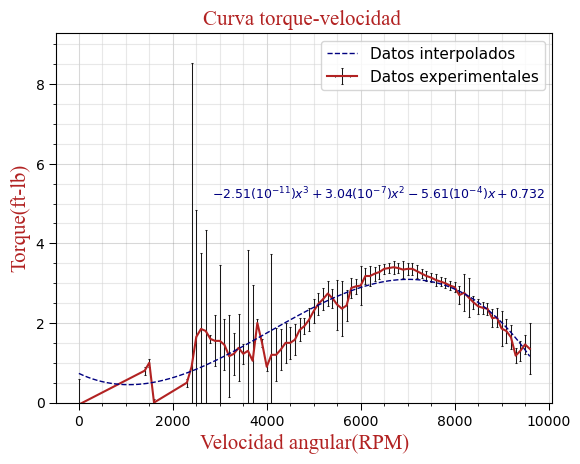

poly1d([-2.51083539e-11,  3.04136754e-07, -5.61037807e-04,  7.32310089e-01])

In [5]:
plot_ufloats(df_grouped.index.to_series(),df_grouped['Torque (ft-lb)'],colore="firebrick")
a=interpolar(df_grouped.index.to_series(),df_grouped['Torque (ft-lb)'],3,colore="navy")
plt.annotate("$-2.51(10^{-11})x^3+3.04(10^{-7})x^2-5.61(10^{-4})x+0.732$",  # Texto de la anotación
             xy=(6300,5),                 # Coordenadas donde se colocará el texto
             xytext=(3, 1),             # Colocamos el texto justo en el punto
             textcoords="offset points",  # Tipo de coordenadas para el texto
             ha='center',                # Alineación horizontal del texto
             va='bottom',
             color="navy",
             fontsize=9) 
grafica("Curva torque-velocidad ","Velocidad angular(RPM)","Torque(ft-lb)")
a

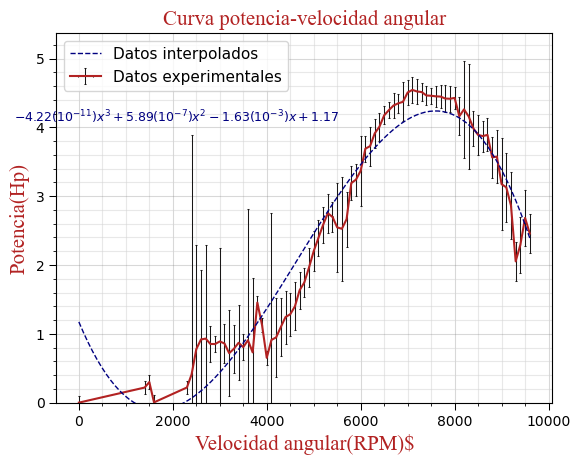

poly1d([-4.22869874e-11,  5.89118760e-07, -1.63143233e-03,  1.17309217e+00])

In [6]:
plot_ufloats(df_grouped.index.to_series(),df_grouped['Hp (Hp)'],colore="firebrick")
a=interpolar(df_grouped.index.to_series(),df_grouped['Hp (Hp)'],3,colore="navy")
plt.annotate("$-4.22(10^{-11})x^3+5.89(10^{-7})x^2-1.63(10^{-3})x+1.17$",  # Texto de la anotación
             xy=(2000,4),                 # Coordenadas donde se colocará el texto
             xytext=(3, 1),             # Colocamos el texto justo en el punto
             textcoords="offset points",  # Tipo de coordenadas para el texto
             ha='center',                # Alineación horizontal del texto
             va='bottom',
             color="navy",
             fontsize=9) 
grafica("Curva potencia-velocidad angular","Velocidad angular(RPM)$","Potencia(Hp)")
a

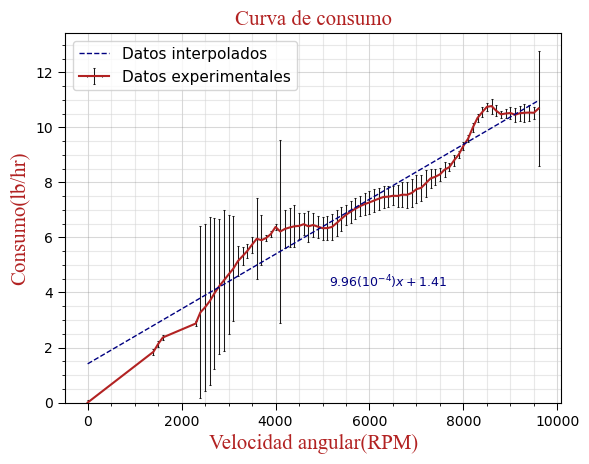

poly1d([9.96560890e-04, 1.40684551e+00])

In [7]:
plot_ufloats(df_grouped.index.to_series(),df_grouped["FuelMass (lb/hr)"],colore="firebrick")
a=interpolar(df_grouped.index.to_series(),df_grouped["FuelMass (lb/hr)"],1,colore="navy")
plt.annotate("$9.96(10^{-4})x+1.41$",  # Texto de la anotación
             xy=(6300,4),                 # Coordenadas donde se colocará el texto
             xytext=(3, 1),             # Colocamos el texto justo en el punto
             textcoords="offset points",  # Tipo de coordenadas para el texto
             ha='center',                # Alineación horizontal del texto
             va='bottom',
             color="navy",
             fontsize=9) 
grafica("Curva de consumo","Velocidad angular(RPM)","Consumo(lb/hr)")
a

In [8]:
df_grouped["Potencia termica"]=(df_grouped["FuelMass (lb/hr)"]*40/2.20462/3600*737562.149/550)

def dividir(row):
    if (row["Potencia termica"]).nominal_value == 0:
        return ufloat(0,0.01)
    else:
        return row['Hp (Hp)'] / row["Potencia termica"]

# Aplicar la función al DataFrame
df_grouped["Eficiencia"] = df_grouped.apply(dividir, axis=1)

df_grouped

,Torque (ft-lb),Hp (Hp),FuelMass (lb/hr),Potencia termica,Eficiencia
RPM (RPM),,,,,
0.00+/-0.10,-0.1+/-0.6,-0.00+/-0.10,0.00+/-0.10,0.0+/-0.7,0.000+/-0.010
1400.00+/-0.10,0.80+/-0.10,0.22+/-0.10,1.84+/-0.10,12.5+/-0.7,0.018+/-0.008
1500.00+/-0.10,1.00+/-0.10,0.30+/-0.10,2.13+/-0.10,14.4+/-0.7,0.021+/-0.007
1600.00+/-0.10,0.00+/-0.10,0.00+/-0.10,2.36+/-0.10,16.0+/-0.7,0.000+/-0.006
2300.00+/-0.10,0.50+/-0.10,0.22+/-0.10,2.87+/-0.10,19.4+/-0.7,0.011+/-0.005
...,...,...,...,...,...
9200.00+/-0.10,1.64+/-0.30,2.9+/-0.5,10.51+/-0.27,71.0+/-1.8,0.040+/-0.007
9300.00+/-0.10,1.18+/-0.19,2.05+/-0.29,10.53+/-0.33,71.2+/-2.2,0.029+/-0.004
9400.00+/-0.10,1.30+/-0.25,2.3+/-0.4,10.54+/-0.29,71.2+/-2.0,0.032+/-0.006


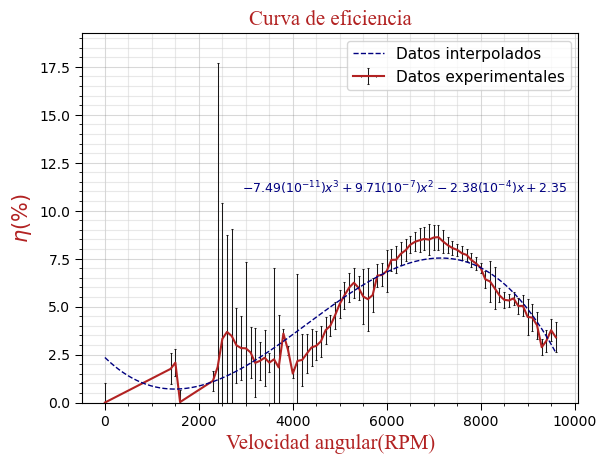

poly1d([-7.49975590e-11,  9.71181219e-07, -2.38491686e-03,  2.34844380e+00])

In [9]:
plot_ufloats(df_grouped.index.to_series(),df_grouped["Eficiencia"]*100,colore="firebrick")
a=interpolar(df_grouped.index.to_series(),df_grouped["Eficiencia"]*100,3    ,colore="navy")
plt.annotate("$-7.49(10^{-11})x^3+9.71(10^{-7})x^2-2.38(10^{-4})x+2.35$",  # Texto de la anotación
             xy=(6300,10.5),                 # Coordenadas donde se colocará el texto
             xytext=(3, 3),             # Colocamos el texto justo en el punto
             textcoords="offset points",  # Tipo de coordenadas para el texto
             ha='center',                # Alineación horizontal del texto
             va='bottom',
             color="navy",
             fontsize=9) 
grafica("Curva de eficiencia","Velocidad angular(RPM)","$\eta(\%)$")
a

In [10]:
max_value = df_grouped["Eficiencia"].max()
registro_max = df_grouped[df_grouped["Eficiencia"] == max_value]
registro_max

,Torque (ft-lb),Hp (Hp),FuelMass (lb/hr),Potencia termica,Eficiencia
RPM (RPM),,,,,
7100.00+/-0.10,3.36+/-0.15,4.54+/-0.19,7.8+/-0.5,52.7+/-3.2,0.086+/-0.006
